# Introduction

__Business Problem:__
We are going to compare the Neighborhoods of New York, US and Toronto, Canada to see how similar are these two cities. We will generally be exploring the attributes provided to us by the FourSquare API.

__Interest:__
In this project we will give analysis which would help suggest the best possible & suitable home location for people across various walks of life. Like Bachelors, Families, Old People etc.
This Analysis is very useful for anyone who is trying to analyze the two cities in terms of the diversity of avenues these two cities offer. This is one of the problem we can try to research through this.
However, this Project will provide the generic Comparison Attributes based on FourSquare data, its Users discretion where ever they want to use it.

In [ ]:
# The code was removed by Watson Studio for sharing.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

#Importing the Beautiful Soup Package from bs4(latest version)
!pip install bs4
from bs4 import BeautifulSoup

print('Libraries imported.')

     |████████████████████████████████| 102kB 17.2MB/s ta 0:00:01
     |████████████████████████████████| 102kB 18.2MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Libraries imported.


In [2]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: LW0YJOGRGRZYTKGIOWV1U4C5GG3GJBELGIDQ2ID3PRZULAOI
CLIENT_SECRET:AHWBIXPOGEZSLLKHYW0ZX2PI1LG43FO0YTIJI24IQBVCGUGK


In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset


with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

#print(neighborhoods_data)

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.rename(columns={"Neighborhood":"Neighbourhood"},inplace=True)

In [4]:
#Making adjustments for some Neighbourhoods having same name across Borough
group = neighborhoods.groupby('Neighbourhood').count()

group = group[group['Borough']>1].reset_index()
group

,Neighbourhood,Borough,Latitude,Longitude
0,Bay Terrace,2,2,2
1,Chelsea,2,2,2
2,Murray Hill,2,2,2
3,Sunnyside,2,2,2


In [5]:
# We will be appending the Borough names to them.

for neigh in list(group['Neighbourhood']):
    for index in neighborhoods[neighborhoods['Neighbourhood']==neigh].index:
        neighborhoods.iloc[index,1] = neigh  + ", " +  neighborhoods[neighborhoods['Neighbourhood']==neigh]['Borough'].unique()[0]


In [6]:
html_doc = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
Soup = BeautifulSoup(html_doc,'html.parser')

# Parsing to the div class which contains the Data of the Table
a = Soup.find('div',class_='mw-content-ltr')
#print(a.table.tr)

# Fetching the Column names for Data Frame
column_nm = []
for th in a.table.tr.find_all('th'):
    column_nm.append(th.text.strip())
print(column_nm)

df = [] # 
sub = [] # Sub list where the data fetched is made in a list of three items and then appended to main list df 
i=0
# looping through the data
for tbl in a.table.find_all('td'):
    
    sub.append(tbl.text.strip())
    #print(tbl.text)
    i+=1
    if (i%3) == 0: # to split the sub into list of three items because we need to create a Data frame of 3 Columns(Postcode,Borough,Neighbourhood)
        df.append(sub)
        sub = []

#Converting the list into Data Frame
Data = pd.DataFrame(df)

# Renaming the Columns
Data.columns=column_nm

#Data

# Replacing "Not assigned" as NA for Column: Borough
Data['Borough'] = Data['Borough'].replace('Not assigned',np.nan)

#Dropping rows with Borough as NA
Data.dropna(subset = ['Borough'],axis=0,inplace=True)

# Resetiing the Index
Data.reset_index(drop=True,inplace=True)

# Replace Neighbours "Not assigned" with Borough
Data["Neighbourhood"] = Data["Neighbourhood"].replace("Not assigned",Data["Borough"] )

# To Combine the Neighbourhood having same Postcodes

df10 = Data.groupby('Postcode')['Neighbourhood'].apply(lambda x: "%s" % ",".join(x))
df10 = df10.to_frame()
df10.reset_index(drop=False,inplace=True)

#No of Unique PostCodes in DataFrame
print(Data['Postcode'].unique().shape)

i=0
df11=[]
# cretaed a list df11 and appending it according to Postcodes in df10(Grouped DataFrame)
for i,pc in enumerate(df10['Postcode']):
    df11.append(Data[Data['Postcode']==pc].Borough.unique()[0])
    if i > len(df10):
        break

# Joining all the Colums to create the Final Data Frame 
df10 = pd.DataFrame({'Postcode':list(df10['Postcode']),'Borough':df11,'Neighbourhood':list(df10['Neighbourhood'])})

url ='https://cocl.us/Geospatial_data'
Coord = pd.read_csv(url)

df10['Latitude'] = Coord[Coord['Postal Code']==df10['Postcode']]['Latitude']
df10['Longitude'] = Coord[Coord['Postal Code']==df10['Postcode']]['Longitude']

df100 = df10.copy()

# df100.reset_index(drop= True, inplace= True)

df100.drop('Postcode',axis=1,inplace=True)

['Postcode', 'Borough', 'Neighbourhood']
(103,)


In [7]:
# We will be appending the Borough names to them.
# No Duplicate Neighbourhood found
g2 = df100.groupby('Neighbourhood').count()
g2[g2['Borough']>1]

,Borough,Latitude,Longitude
Neighbourhood,,,


In [10]:
print(df100.shape)
df100.head()

(103, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
print(neighborhoods.shape)
neighborhoods.head()

(306, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [ ]:
venues = getNearbyVenues(names=neighborhoods['Neighbourhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

# print(venues.shape)
# venues.head()

venues.groupby('Neighbourhood').count()

In [16]:
# Saving the Data for NewYork City venues
#project.save_data("venues.csv", venues.to_csv())
venues.to_csv("venues.csv")

In [111]:
venues_toronto = getNearbyVenues(names=df100['Neighbourhood'],
                                   latitudes=df100['Latitude'],
                                   longitudes=df100['Longitude']
                                  )

print(venues_toronto.shape)
venues_toronto.head()

venues_toronto.groupby('Neighbourhood').count()

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",3,3,3,3,3,3
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",9,9,9,9,9,9
"Alderwood,Long Branch",10,10,10,10,10,10
"Bathurst Manor,Downsview North,Wilson Heights",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55


In [17]:
# Saving Toronto venue data
#project.save_data('venues_toronto1.csv',venues_toronto.to_csv())
venues_toronto.to_csv('venues_toronto1.csv')

In [116]:
venues_toronto.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [2]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa


In [7]:
# Importing from Skills Lab
df_data_1 = pd.read_csv('venues.csv')
df_data_2 = pd.read_csv('venues_toronto1.csv')

In [8]:
Toronto = df_data_2.drop('Unnamed: 0',axis=1)
Newyork = df_data_1.drop('Unnamed: 0',axis=1)

In [95]:
Toronto.head()
# Newyork.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa



No of Rows for each City is having a lot of difference
NewYork has 10402 rows
while Toronto has 1702 rows of Data

In [9]:
# one hot encoding
Newyork_onehot = pd.get_dummies(Newyork[['Venue Category']], prefix="", prefix_sep="")
#print(Newyork_onehot.head())
# add neighborhood column back to dataframe
Newyork_onehot['Neighbourhood'] = Newyork['Neighbourhood'] 
#print(Newyork_onehot.head())
# move neighborhood column to the first column
fixed_columns = [Newyork_onehot.columns[-1]] + list(Newyork_onehot.columns[:-1])
#print(Newyork_onehot.columns[:-1])
Newyork_onehot = Newyork_onehot[fixed_columns]

Newyork_onehot.head()

Newyork_grouped = Newyork_onehot.groupby('Neighbourhood').sum(axis=0).reset_index()
Newyork_grouped['Total']=Newyork_grouped.sum(axis=1)


In [36]:
#venues_sorted[venues_sorted['Neighbourhood'] == 'Annadale']
Newyork_grouped.shape

(305, 430)

In [12]:
#For Toronto

# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto[['Venue Category']], prefix="", prefix_sep="")
#print(Toronto_onehot.head())
# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto['Neighbourhood'] 
#print(Toronto_onehot.head())
# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
#print(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

Toronto_grouped= Toronto_onehot.groupby('Neighbourhood').sum(axis=0).reset_index()
Toronto_grouped['Total']=Toronto_grouped.sum(axis=1)

In [13]:
#venue_grouped.head()
Toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Stor

In [14]:
Toronto_grouped.shape

(99, 279)

In [15]:
Newyork_grouped.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Gre

#### There is a big difference between the number of Neighbourhood list of New York City and Toronto, so we will take first 100 densely populated neighbourhoods according to the number of venues available for them.

In [14]:
# Now Extract the top 100 Neighbourhoods according to Column "Total" 

# Top 100 Toronto Neighbourhoods
Newyork_100=Newyork_grouped.sort_values('Total',ascending=False).head(100).reset_index(drop =True)
#Newyork_100['Borough'] = 
# Top 100 NewYork City Neighbourhoods
Toronto_100=Toronto_grouped.sort_values('Total',ascending=False).head(100).reset_index(drop =True)

Toronto_10 = Toronto_100.head(10)

In [24]:
Toronto_100.head()
Newyork_100.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Gre

In [15]:
df11=[]
df12 = []
df13 =[]
for i,pc in enumerate(Toronto_10['Neighbourhood']):
    df11.append(df100[df100['Neighbourhood']==pc].Borough.unique()[0])
    df12.append(df100[df100['Neighbourhood']==pc].Latitude.unique()[0])
    df13.append(df100[df100['Neighbourhood']==pc].Longitude.unique()[0])
    if i > len(Toronto_10):
        break


Toronto_10_visio = pd.DataFrame({'Borough':df11,'Neighbourhood':list(Toronto_10['Neighbourhood']),'Latitude': df12,'Longitude': df13})

### Visualizing the 5 most Venue rich Neighbourhoods in Toronto

In [16]:

# create map of Toronto using latitude and longitude values
import folium
Toronto_map = folium.Map(location =[43.653963, -79.387207],zoom_start = 14)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_10_visio.head(5)['Latitude'], Toronto_10_visio.head(5)['Longitude'],Toronto_10_visio.head(5)['Borough'], Toronto_10_visio.head(5)['Neighbourhood']):
    label = '{} '.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  

Toronto_map

##### We can notice that the 5 most happening places in Toronto is in Downtown Toronto


In [21]:
Toronto_10_visio.head(5)

### Visualizing the 5 most Venue rich Neighbourhoods in NewYork

#### Newyork has 35 rows of neighbourhoods which has 100 count of venues, lets explore these neighbourhoods more without having LIMIT as parameter,lets take count of results and save them as different DataFrame

In [18]:
Newyork_35=Newyork_100.head(35)
df11=[]
df12 = []
df13 =[]
for i,pc in enumerate(Newyork_35['Neighbourhood']):
    df11.append(neighborhoods[neighborhoods['Neighbourhood']==pc].Borough.unique()[0])
    df12.append(neighborhoods[neighborhoods['Neighbourhood']==pc].Latitude.unique()[0])
    df13.append(neighborhoods[neighborhoods['Neighbourhood']==pc].Longitude.unique()[0])
    if i > len(Newyork_35):
        break


Newyork_35_visio = pd.DataFrame({'Borough':df11,'Neighbourhood':list(Newyork_35['Neighbourhood']),'Latitude': df12,'Longitude': df13})

def getvenuenum(Borough, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for boro, name, lat, lng in zip(Borough, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()['response']['totalResults']
        
        # return only relevant information for each nearby venue
        venues_list.append([(boro,
            name, 
            lat, 
            lng, 
            results)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 'Neighbourhood','Neighbourhood_Latitude','Neighbourhood_Longitude','No_of_results']
    
    return(nearby_venues)



venues_top_35 = getvenuenum(Borough = Newyork_35_visio['Borough'].head(35) ,names=Newyork_35_visio['Neighbourhood'].head(35),
                                   latitudes=Newyork_35_visio['Latitude'].head(35),
                                   longitudes=Newyork_35_visio['Longitude'].head(35)
                                  )


In [19]:
# Incase Quota is finished use below:
#venues_top_35.to_csv('Newyork_35.csv')
venues_top_35 =pd.read_csv('Newyork_35.csv')

In [20]:
Newyork_10_visio=venues_top_35.sort_values('No_of_results',ascending=False).head(10).reset_index(drop=True)

In [21]:
# Most popular Borough's in Newyork 
# print(Newyork_10_visio.Borough.unique())
Newyork_10_visio.head(5)

,Unnamed: 0,Borough,Neighbourhood,Neighbourhood_Latitude,Neighbourhood_Longitude,No_of_results
0,14,Manhattan,Greenwich Village,40.726933,-73.999914,237
1,4,Manhattan,Chinatown,40.715618,-73.994279,235
2,16,Manhattan,Little Italy,40.719324,-73.997305,234
3,10,Manhattan,Financial District,40.707107,-74.010665,229
4,17,Manhattan,Midtown,40.754691,-73.981669,228


In [22]:

# create map of Newyork using latitude and longitude values
import folium
Newyork_map = folium.Map(location =[40.730610,-73.935242],zoom_start = 12)

# add markers to map
for lat, lng, borough, neighborhood in zip(Newyork_10_visio.head(5)['Neighbourhood_Latitude'], Newyork_10_visio.head(5)['Neighbourhood_Longitude'],Newyork_10_visio.head(5)['Borough'], Newyork_10_visio.head(5)['Neighbourhood']):
    label = '{} '.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Newyork_map)  

Newyork_map

In [35]:
# The code was removed by Watson Studio for sharing.

# Let's Explore the venue Categories in Toronto and Newyork for these 10 most popular Neighborhoods.

In [23]:
# Newyork_10_visio
# Toronto_10_visio
Newyork_grouped1=Newyork_grouped.copy()
Newyork_grouped1.reset_index(drop=True)
# Newyork_grouped1.head()
indexl=[]
for neigh in list(Newyork_10_visio['Neighbourhood']):
    for index in Newyork_grouped1[Newyork_grouped1['Neighbourhood']==neigh].index:
        indexl.append(index)

Newyork_10=Newyork_grouped.iloc[indexl]
Newyork_10.head()

,Neighbourhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Gre

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [25]:
# create a new dataframe
Newyork_sorted = pd.DataFrame(columns=columns)
Newyork_sorted['Neighbourhood'] = Newyork_10['Neighbourhood']

for ind in np.arange(Newyork_10.shape[0]):
    Newyork_sorted.iloc[ind, 1:] = return_most_common_venues(Newyork_10.iloc[ind, 0:(Newyork_10.shape[1]-1)], num_top_venues)

Newyork_sorted.reset_index(drop=True,inplace=True)

In [26]:
Toronto_sorted = pd.DataFrame(columns=columns)
Toronto_sorted['Neighbourhood'] = Toronto_10['Neighbourhood']

for ind in np.arange(Toronto_10.shape[0]):
    Toronto_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_10.iloc[ind, 0:(Toronto_10.shape[1]-1)], num_top_venues)

__One Observation, which is very prevalent is that Toronto has a lot of coffee Shops.__

In [27]:
Newyork_10.reset_index(drop=True,inplace=True)

Newyork_comb = pd.DataFrame({'Venue':[],'Count':[]})
# Newyork_comb
# del Newyork_comb

for ind in np.arange(Newyork_10.shape[0]):
    Newyork_comb1 = pd.DataFrame({'Venue':list(Newyork_10.iloc[ind,0:(Newyork_10.shape[1]-1)].iloc[1:].sort_values(ascending=False)[0:10].reset_index(drop=False).iloc[0:10,0]),'Count':list(Newyork_10.iloc[ind,0:(Newyork_10.shape[1]-1)].iloc[1:].sort_values(ascending=False)[0:10].reset_index(drop=False).iloc[0:10,1])})
    Newyork_comb=Newyork_comb.append(Newyork_comb1,ignore_index=True)    

Newyork_comb = Newyork_comb.groupby('Venue').sum().reset_index(drop=False).sort_values('Count',ascending=False).set_index('Venue',drop=True)

Newyork_comb.head()

,Count
Venue,
Coffee Shop,28.0
Hotel,19.0
Italian Restaurant,19.0
Cocktail Bar,19.0
American Restaurant,17.0


In [28]:
Toronto_10.reset_index(drop=True,inplace=True)

Toronto_comb = pd.DataFrame({'Venue':[],'Count':[]})

for ind in np.arange(Toronto_10.shape[0]):
    Toronto_comb1 = pd.DataFrame({'Venue':list(Toronto_10.iloc[ind,0:(Toronto_10.shape[1]-1)].iloc[1:].sort_values(ascending=False)[0:10].reset_index(drop=False).iloc[0:10,0]),'Count':list(Toronto_10.iloc[ind,0:(Toronto_10.shape[1]-1)].iloc[1:].sort_values(ascending=False)[0:10].reset_index(drop=False).iloc[0:10,1])})
    Toronto_comb=Toronto_comb.append(Toronto_comb1,ignore_index=True)    

Toronto_comb = Toronto_comb.groupby('Venue').sum().reset_index(drop=False).sort_values('Count',ascending=False).set_index('Venue',drop=True)

Toronto_comb.head()

,Count
Venue,
Coffee Shop,88.0
Café,53.0
Hotel,33.0
Restaurant,31.0
Bar,15.0


In [104]:
# The code was removed by Watson Studio for sharing.

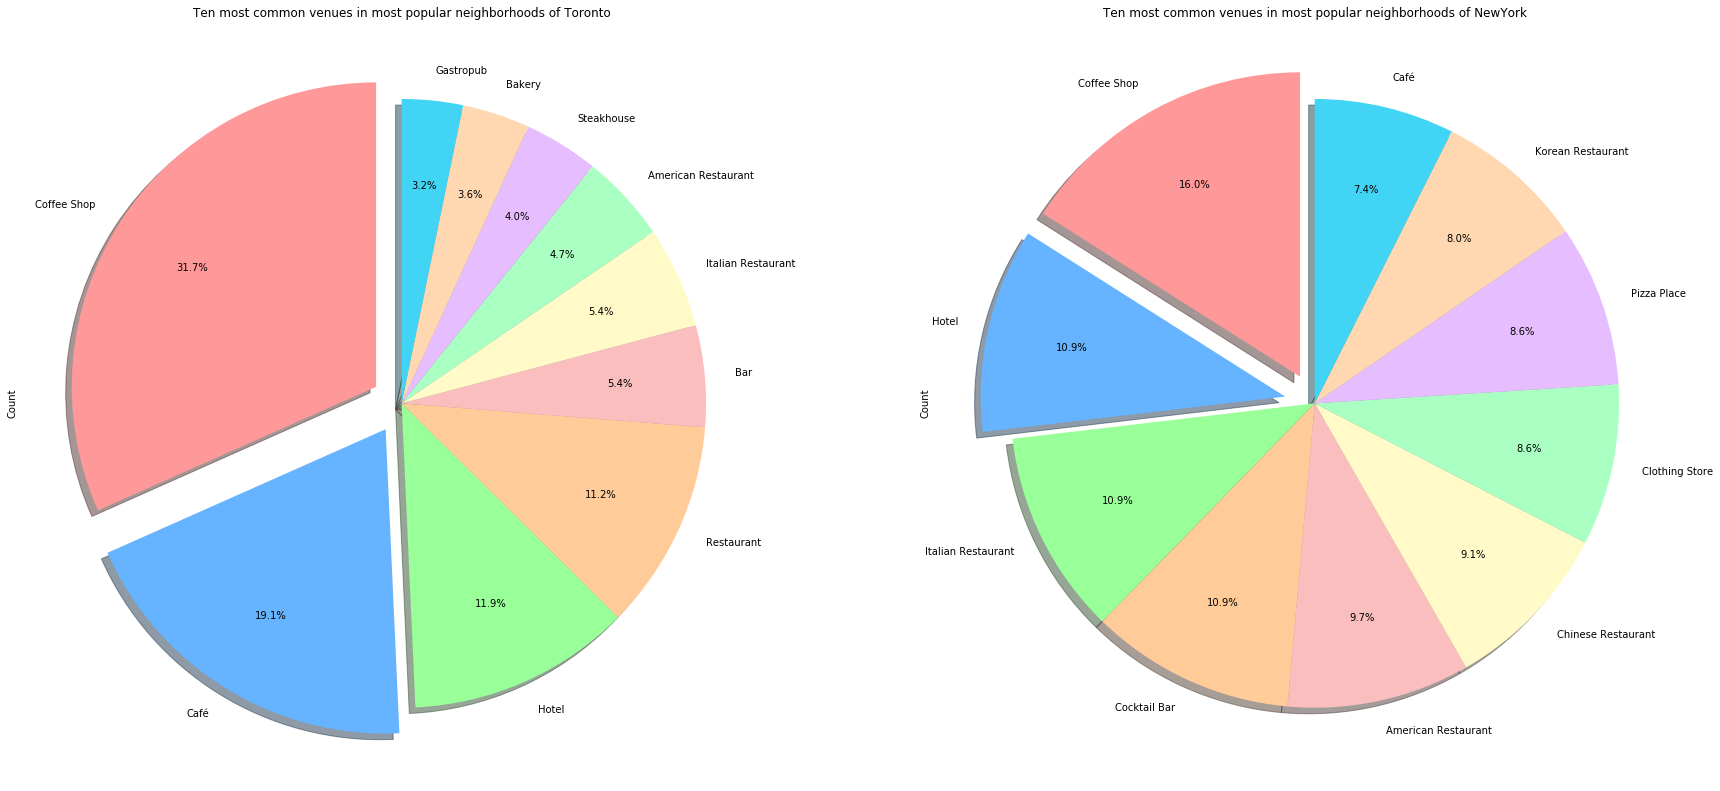

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,20)) # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)

explode_list = [0.1,0.1,0,0,0,0,0,0,0,0]
colors_list = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#fabebe','#fffac8','#aaffc3','#e6beff','#ffd8b1','#42d4f4']

Toronto_comb['Count'].head(10).plot(kind='pie',
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,
                            pctdistance=0.72,           # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,         # add custom colors
                            explode=explode_list,ax=ax0)

ax0.set_title("Ten most common venues in most popular neighborhoods of Toronto")


Newyork_comb['Count'].head(10).plot(kind='pie',
                            autopct='%1.1f%%', 
                            startangle=90,     
                            shadow=True,
                            pctdistance=0.72,           # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,         # add custom colors
                            explode=explode_list,ax=ax1)

ax1.set_title("Ten most common venues in most popular neighborhoods of NewYork")

# plt.axis('equal')
# plt.tight_layout()
plt.show()

In [64]:
# The code was removed by Watson Studio for sharing.

In [63]:
# The code was removed by Watson Studio for sharing.

In [62]:
# The code was removed by Watson Studio for sharing.

## Clusturing the Neighbourhoods to find out which are the Neighbourhoods which are similar between Toronto and New York. 

In [31]:
# Merging the venues data for Toronto and Newyork to create one data set so as to have 

merge1 = pd.merge(Toronto,df100[['Neighbourhood','Borough']],on='Neighbourhood',how='inner')
merge2 = pd.merge(Newyork,neighborhoods[['Neighbourhood','Borough']],on='Neighbourhood',how='inner')

merge1.iloc[100:150]
City1= list(np.repeat('Toronto',Toronto.shape[0]))
City2 = list(np.repeat('New York',Newyork.shape[0]))
merge1['City'] = City1
merge2['City'] = City2

Tor_New = merge1.append(merge2)
Tor_New.head()
# del(Tor_New)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,City
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant,Scarborough,Toronto
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar,Scarborough,Toronto
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,Scarborough,Toronto
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store,Scarborough,Toronto
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa,Scarborough,Toronto


In [32]:
Tor_New.shape

(12627, 9)

In [33]:
# one hot encoding
Tor_New_onehot = pd.get_dummies(Tor_New[['Venue Category']], prefix="", prefix_sep="")
#print(Tor_New_onehot.head())

# add neighborhood column back to dataframe
Tor_New_onehot[['Neighbourhood','Borough','City']] = Tor_New[['Neighbourhood','Borough','City']] 
#print(Tor_New_onehot.head())

# move neighborhood column to the first column
fixed_columns = [Tor_New_onehot.columns[-1]] + [Tor_New_onehot.columns[-2]] + [Tor_New_onehot.columns[-3]] + list(Tor_New_onehot.columns[:-3])

#print(Tor_New_onehot.columns[:-1])
Tor_New_onehot = Tor_New_onehot[fixed_columns]

Tor_New_onehot['Neighbourhood'] = Tor_New_onehot['Neighbourhood']+", "+Tor_New_onehot['Borough']+", "+Tor_New_onehot['City']

# Tor_New_onehot.head()
Tor_New_grouped = Tor_New_onehot.iloc[:,2:].groupby('Neighbourhood').sum(axis=0).reset_index()

# del(Tor_New_grouped)
# del(Tor_New_onehot)

In [34]:
# create a new dataframe
Tor_New_venues_sorted = pd.DataFrame(columns=columns)
Tor_New_venues_sorted['Neighbourhood'] = Tor_New_grouped['Neighbourhood']

# Tor_New_venues_sorted.head()
for ind in np.arange(Tor_New_grouped.shape[0]):
    Tor_New_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tor_New_grouped.iloc[ind, :], num_top_venues)

Tor_New_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond, Downtown Toronto, Toronto",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,American Restaurant,Hotel,Thai Restaurant,Cosmetics Shop,Restaurant
1,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Zoo Exhibit,Fast Food Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
2,"Agincourt, Scarborough, Toronto",Breakfast Spot,Skating Rink,Lounge,Clothing Store,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Sandwich Place,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Pharmacy,Beer Store,Coffee Shop,Factory,Falafel Restaurant
4,"Alderwood,Long Branch, Etobicoke, Toronto",Pizza Place,Pharmacy,Sandwich Place,Coffee Shop,Athletics & Sports,Pool,Gym,Pub,Skating Rink,Empanada Restaurant


In [35]:
# set number of clusters
kclusters = 11 #Toronto has 11 Borough, by creating 11 clusters we are going to try to group different neighborhoods of Toronto and Newyork.
                #This is to see which Boroughs are similar.

Tor_New_grouped_clustering = Tor_New_grouped.drop('Neighbourhood', 1)
# Tor_New_grouped_clustering.head()

#run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tor_New_grouped_clustering)

#check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 5, 5, 5, 5, 0, 5, 5, 5, 0], dtype=int32)

In [36]:
# add clustering labels
# Tor_New_venues_sorted.drop(Tor_New_venues_sorted.columns[0],axis=1,inplace=True)
# Tor_New_venues_sorted.head()

Tor_New_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

## Let's Examine the Clusters generated to have some insights on the similarity of Toronto and New York.

In [41]:
Tor_New_venues_sorted.loc[Tor_New_venues_sorted['Cluster Labels'] == 0][50:60]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
205,0,"Kew Gardens Hills, Queens, New York",Bank,Pizza Place,Sushi Restaurant,Playground,Middle Eastern Restaurant,Bagel Shop,Supermarket,Bus Station,Gift Shop,Deli / Bodega
206,0,"Kew Gardens, Queens, New York",Chinese Restaurant,Bar,Pizza Place,Bank,Cosmetics Shop,Donut Shop,Deli / Bodega,Indian Restaurant,Bus Station,Optical Shop
211,0,"L'Amoreaux West, Scarborough, Toronto",Chinese Restaurant,Fast Food Restaurant,Pizza Place,American Restaurant,Breakfast Spot,Grocery Store,Pharmacy,Coffee Shop,Sandwich Place,Thrift / Vintage Store
216,0,"Lefrak City, Queens, New York",Bakery,Cosmetics Shop,Department Store,Bistro,Liquor Store,Dry Cleaner,Bank,Shopping Mall,Mexican Restaurant,Supplement Shop
230,0,"Manhattan Terrace, Brooklyn, New York",Pizza Place,Donut Shop,Bagel Shop,Deli / Bodega,Bank,Coffee Shop,Mobile Phone Shop,Bus Station,Restaurant,Grocery Store
233,0,"Manor Heights, Staten Island, New York",Donut Shop,Campground,Deli / Bodega,Chinese Restaurant,Liquor Store,American Restaurant,Pharmacy,Sushi Restaurant,Bagel Shop,Pizza Place
234,0,"Marble Hill, Manhattan, New York",Sandwich Place,Coffee Shop,American Restaurant,Steakhouse,Pizza Place,Supplement Shop,Miscellaneous Shop,Tennis Stadium,Gym,Bank
238,0,"Maspeth, Queens, New York",Pizza Place,Diner,Grocery Store,Bank,Mobile Phone Shop,Taco Place,Vape Store,Discount Store,Sandwich Place,Pharmacy
239,0,"Melrose, Bronx, New York",Pharmacy,Pizza Place,Discount Store,Supermarket,Art Gallery,Martial Arts Dojo,Gym,Gym / Fitness Center,Mexican Restaurant,Liquor Store
244,0,"Midwood, Brooklyn, New York",Pizza Place,Pharmacy,Bakery,Video Game Store,Candy Store,Ice Cream Shop,Bank,Convenience Store,Italian Restaurant,English Restaurant


In [61]:
# Cluster Number 11
Tor_New_venues_sorted.loc[Tor_New_venues_sorted['Cluster Labels'] == 10]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,10,"Astoria, Queens, New York",Middle Eastern Restaurant,Bar,Greek Restaurant,Hookah Bar,Seafood Restaurant,Bakery,Mediterranean Restaurant,Pizza Place,Gym / Fitness Center,Grocery Store
21,10,"Bayside, Queens, New York",Bar,Pizza Place,Pub,Greek Restaurant,Sushi Restaurant,American Restaurant,Indian Restaurant,Mexican Restaurant,Italian Restaurant,Bakery
52,10,"Bushwick, Brooklyn, New York",Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Bakery,Discount Store,Thrift / Vintage Store,New American Restaurant,Diner
73,10,"Chinatown,Grange Park,Kensington Market, Downt...",Café,Vegetarian / Vegan Restaurant,Bar,Vietnamese Restaurant,Mexican Restaurant,Chinese Restaurant,Dumpling Restaurant,Bakery,Coffee Shop,Farmers Market
89,10,"Cobble Hill, Brooklyn, New York",Pizza Place,Coffee Shop,Bar,Italian Restaurant,Playground,Deli / Bodega,Ice Cream Shop,Yoga Studio,Cocktail Bar,Thai Restaurant
125,10,"East Village, Manhattan, New York",Bar,Wine Bar,Ice Cream Shop,Pizza Place,Chinese Restaurant,Mexican Restaurant,Ramen Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Korean Restaurant
126,10,"East Williamsburg, Brooklyn, New York",Bar,Cocktail Bar,Coffee Shop,Bakery,Deli / Bodega,Mexican Restaurant,Concert Hall,Vegetarian / Vegan Restaurant,Café,Sandwich Place
163,10,"Gowanus, Brooklyn, New York",Bar,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Art Gallery,Chinese Restaurant,Mexican Restaurant,Coffee Shop,Rental Car Location,Wine Shop
164,10,"Gramercy, Manhattan, New York",Bar,Italian Restaurant,Bagel Shop,Pizza Place,American Restaurant,Grocery Store,Coffee Shop,Cocktail Bar,Thrift / Vintage Store,Mexican Restaurant
170,10,"Greenpoint, Brooklyn, New York",Bar,Pizza Place,Coffee Shop,Cocktail Bar,French Restaurant,Café,Mexican Restaurant,Yoga Studio,Record Shop,Boutique
